In [16]:
!apt-get install -y git
!git config --global user.email "cedric.g1800@hotmail.com"
!git config --global user.name "CeddyG1"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [17]:
!git clone https://github.com/CeddyG1/colab-github-demo-CG.git
%cd colab-github-demo-CG
!ls

Cloning into 'colab-github-demo-CG'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/colab-github-demo-CG
README.md


In [ ]:
!pip install yfinance ta --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install ta yfinance gradio keras-tuner --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, EMAIndicator

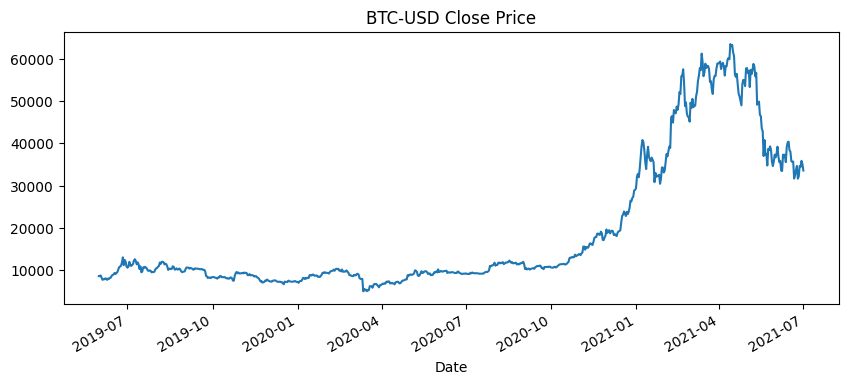

In [ ]:
PATH = "BTC-USD.csv"

df = pd.read_csv(PATH, parse_dates=['Date'])
df.sort_values('Date', inplace=True)          # chronological order
df.reset_index(drop=True, inplace=True)

# Quick visual sanity check
df.set_index('Date')['Close'].plot(figsize=(10,4), title="BTC-USD Close Price")
plt.show()

In [ ]:
# 2.1  Log returns
df['log_ret'] = np.log(df['Close']).diff()

# 2.2  Moving averages (change windows as you like)
for wnd in (10, 21, 50):
    df[f'sma_{wnd}'] = SMAIndicator(df['Close'], wnd).sma_indicator()
    df[f'ema_{wnd}'] = EMAIndicator(df['Close'], wnd).ema_indicator()

# 2.3  Bollinger Bands
bb = BollingerBands(close=df['Close'])
df['bb_high'], df['bb_low'] = bb.bollinger_hband(), bb.bollinger_lband()

# 2.4  Drop NA rows created by indicators
df.dropna(inplace=True)

# 2.5  Scale everything except the date for the neural net
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.drop(['Date'], axis=1))

In [ ]:
LOOKBACK = 30   # past 30 days
HORIZON  = 1    # predict 1-day-ahead Close

def make_sequences(data, lb=LOOKBACK, horizon=HORIZON):
    X, y = [], []
    for i in range(lb, len(data) - horizon):
        X.append(data[i-lb:i])
        y.append(data[i + horizon - 1, df.columns.get_loc('Close') - 1])  # Close col index after drop
    return np.array(X), np.array(y)

X, y = make_sequences(scaled)
split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = X[:split], y[:split], X[split:], y[split:]


In [ ]:
import tensorflow as tf, keras_tuner

# 4.1 Baseline (naïve “yesterday = today”)
rmse_naive = np.sqrt(np.mean((y_test - X_test[:, -1, df.columns.get_loc('Close') - 1])**2))

# 4.2  Build + tune LSTM
def build_lstm(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(hp.Int("units1", 32, 128, step=32),
                             return_sequences=True,
                             input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(hp.Float("drop1", 0.1, 0.5, step=0.1)),
        tf.keras.layers.LSTM(hp.Int("units2", 16, 64, step=16)),
        tf.keras.layers.Dropout(hp.Float("drop2", 0.1, 0.5, step=0.1)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = keras_tuner.RandomSearch(
    build_lstm, objective='val_loss', max_trials=10, overwrite=True)
tuner.search(X_train, y_train, epochs=25, validation_split=0.2, verbose=0)

best_model = tuner.get_best_models()[0]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
LSTM RMSE = 0.09  |  Naïve RMSE = 0.04


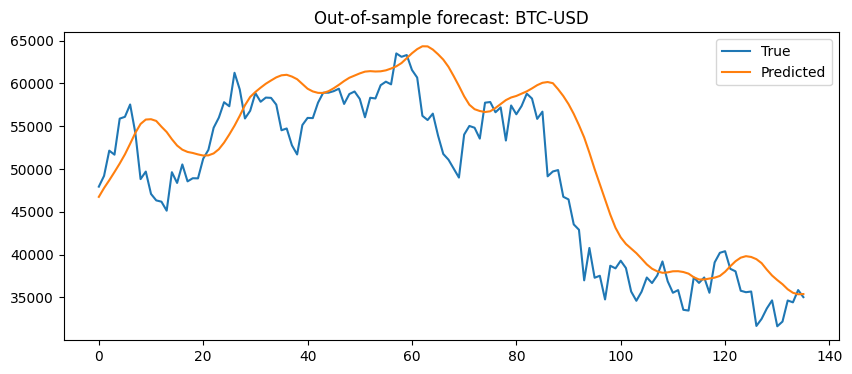

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred_scaled = best_model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, pred_scaled))
mae  = mean_absolute_error(y_test, pred_scaled)

# Invert scaling
def inverse_close(scaled_close):
    # Re-shape so scaler.inverse_transform can work
    temp = np.zeros((len(scaled_close), scaled.shape[1]))
    temp[:, df.columns.get_loc('Close') - 1] = scaled_close
    return scaler.inverse_transform(temp)[:, df.columns.get_loc('Close') - 1]

pred = inverse_close(pred_scaled)
true = inverse_close(y_test)

print(f"LSTM RMSE = {rmse:.2f}  |  Naïve RMSE = {rmse_naive:.2f}")

plt.figure(figsize=(10,4))
plt.plot(true, label='True')
plt.plot(pred, label='Predicted')
plt.title('Out-of-sample forecast: BTC-USD')
plt.legend(); plt.show()

In [ ]:
import gradio as gr, datetime

def forecast(days_ahead=1):
    # Use most recent LOOKBACK window
    latest_seq = scaled[-LOOKBACK:].reshape(1, LOOKBACK, -1)
    pred_scaled = best_model.predict(latest_seq).flatten()
    pred_price  = inverse_close(pred_scaled)[0]
    date = df['Date'].iloc[-1] + datetime.timedelta(days=days_ahead)
    return f"Predicted close on {date.date()}: ${pred_price:,.2f}"

demo = gr.Interface(
    fn=forecast,
    inputs=gr.Slider(1, 5, value=1, label="Days ahead"),
    outputs="text",
    title="BTC-USD Next-Day Price Forecaster")
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b100a01fae5d6af121.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
